In [2]:
import nltk,re,time,umap,collections,wordcloud,sys,os
os.path.append('../')
from sentence_transformers import SentenceTransformer,models
import plotly.express as px
import pandas as pd
import mlflow
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from modules import utils

from hdbscan import HDBSCAN
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
%reload_ext utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

from scipy.spatial.distance import pdist, squareform

from flair.models import SequenceTagger
from flair.data import Sentence

TOP_N = 100


ImportError: attempted relative import with no known parent package

#### Load Flair-based NER 

In [164]:
tagger = SequenceTagger.load('de-ner-germeval')
sentence = Sentence('George Washington ging nach Washington.')
tagger.predict(sentence)

2020-10-22 00:35:21,078 loading file /Users/tomasztkaczyk/.flair/models/de-ner-germeval-0.4.1.pt


## Load the Google's NER Tags for the labeled articles 

In [140]:
labeled = pd.read_csv("./raw_article_entities.csv",header=None,names=["_id","article_id","kicker_headline","text_ne","seo_title_ne","created_at_ne","updated_at","parset"])

labeled.drop(["parset","updated_at","_id"],axis=1,inplace=True)
labeled=labeled.set_index("article_id")
print(labeled.shape)
labeled.head(1)

(240, 4)


,kicker_headline,text_ne,seo_title_ne,created_at_ne
article_id,,,,
080f9e0033f23540881fd07ecbf503e9066c5151ddb82287852b1badfcad4e7d,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-09 15:52:04


# Load the labeled Clusters and join them with NER from HUD DB

In [222]:
X = utils.load_labeled_data()

X.drop(["site","entities_analyzed","updated_at"],inplace=True,axis="columns")
y_summarized_clusters = dict(collections.Counter(y))

X['mix'] =  X['headline'] +" "+ X["seo_title"].apply(utils.remove_seo_title_marker) #+ X["text"].apply(lambda x: " ".join(x.split(" ")[:150]))
#pdf_mix = utils.preprocess_text(X,col="mix")
pdf_mix = X["mix"].values
X = X.join(labeled,how='right')
X.drop_duplicates(subset='headline',inplace=True)
pdf= utils.preprocess_text(X,"text")

X.head(3)

,labels,headline,seo_title,text,created_at_date,created_at,mix,kicker_headline,text_ne,seo_title_ne,created_at_ne
01041edd835d23b5fc1da3f45bd9eecee20712902612a075ee68873bcdfba708,22,"Die große Analyse - Welche Versicherung muss sein, welche ist Quatsch? *** BILDplus Inhalt *** -Wirtschaft -Bild.de","Welche Versicherung muss sein, welche ist Quatsch?","Corona-Krise, Kurzarbeit, steigende Arbeitslosigkeit: Millionen haben gerade Angst um ihre Finanzen. Ein großer Kostenblock für viele sind Versicherungen. Welche ist wichtig, welche kann man sich sparen? Lesen Sie nur mit BILD plus die große Versicherungs-Analyse!",9/12/20,2020-09-12 23:24:15,"Die große Analyse - Welche Versicherung muss sein, welche ist Quatsch? *** BILDplus Inhalt *** -Wirtschaft -Bild.de","[{""entities"":[{""mentions"":[{""text"":{""content"":""Analyse"",""beginOffset"":11},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Analyse"",""type"":""OTHER"",""salience"":0.4083549380302429,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Quatsch"",""beginOffset"":61},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Quatsch"",""type"":""OTHER"",""salience"":0.3228294253349304,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Versicherung"",""beginOffset"":26},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Versicherung"",""type"":""ORGANIZATION"",""salience"":0.26881563663482666,""sentiment"":null}],""language"":""de""},null,null]","[{""entities"":[{""mentions"":[{""text"":{""content"":""Kurzarbeit"",""beginOffset"":14},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Kurzarbeit"",""type"":""OTHER"",""salience"":0.29490000009536743,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Arbeitslosigkeit"",""beginOffset"":36},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Arbeitslosigkeit"",""type"":""OTHER"",""salience"":0.19496002793312073,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Angst"",""beginOffset"":77},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Angst"",""type"":""OTHER"",""salience"":0.11731062084436417,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Finanzen"",""beginOffset"":91},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Finanzen"",""type"":""OTHER"",""salience"":0.11731062084436417,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Corona-Krise"",""beginOffset"":0},""type"":""PROPER"",""sentiment"":null}],""metadata"":{""mid"":""/g/11fr15t15h"",""wikipedia_url"":""https://en.wikipedia.org/wiki/COVID-19_pandemic""},...","[{""entities"":[{""mentions"":[{""text"":{""content"":""Analyse"",""beginOffset"":11},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Analyse"",""type"":""WORK_OF_ART"",""salience"":0.42783594131469727,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Versicherung"",""beginOffset"":28},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Versicherung"",""type"":""ORGANIZATION"",""salience"":0.29629403352737427,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Quatsch"",""beginOffset"":63},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Quatsch"",""type"":""OTHER"",""salience"":0.1511181890964508,""sentiment"":null},{""mentions"":[{""text"":{""content"":""BILDplus Inhalt *** -Wirtschaft -Bild.de"",""beginOffset"":76},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""BILDplus Inhalt *** -Wirtschaft -Bild.de"",""type"":""OTHER"",""salience"":0.12475184351205826,""sentiment"":null}],""language"":""de""},null,null]",2020-09-12 23:25:05
0177704b8dba48b9f78a4e7e40bdf147ca407c121f32e2cf109e62ff16c64708,17,"Dortmund: Tierschützer retten verwahrloste Dackel, Kaninchen und Tauben -Ruhrgebiet -Bild.de",Tierschützer retten völlig verwahrloste Dackel,"Dortmund – Diese Hilfs-Aktion hat wahrscheinlich Leben gerettet. In Dortmund holten Tierschützer verwahrlost

In [223]:
y= X["labels"]
X.drop("labels",axis=1,inplace=True)

In [224]:


def ner_article(text,threshold = 0.70,log_spans=False,*kwargs):
    sentence = Sentence(text)
    tagger.predict(sentence,mini_batch_size=60,*kwargs)
    if log_spans:
        ctr = collections.Counter([ x.to_dict()["text"] for x in sentence.get_spans('ner')])
        print(ctr.most_common())
        #
        
    return [ x.to_dict() for x in sentence.get_spans('ner') if x.score > threshold]


ner_labels =ner_article(X["text"].iloc[26])
ctr = collections.Counter([x["text"] for x in ner_labels])
print(ctr.most_common())

[('Waghäusel', 2), ('Karlsruhe', 1), ('A5', 1), ('Landau', 1), ('Autobahn 5', 1), ('Kronau', 1), ('Reptilienzoo Landau', 1)]


In [213]:
## Parsing utilities

flatten = lambda t: [item for sublist in t for item in sublist] #Flatten list of lists
dedupe = lambda list_of_objects :[i for n, i in enumerate(list_of_objects) if i not in list_of_objects[n + 1:]] # Deduplicated list of objects

### Cluster descriotion evaluation 

In [225]:

docs_df = pd.DataFrame(pdf, columns=["Doc"])
docs_df['Topic'] = y.values
docs_df['Doc_ID'] = X.index.values #df["article_uid"]#range(len(docs_df))
docs_df["Raw_Doc"] =  X["text"].values
docs_df["mix"] = X["mix"].values
docs_df["kicker_headline"] = X.kicker_headline.values
docs_df["text_ne"] = X.text_ne.values


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join,
                                                                   'Raw_Doc': ' '.join,
                                                                   'mix': ' '.join,
                                                                    "kicker_headline":lambda x: (flatten([parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (flatten([parse_google_named_entities(el) for el in x ]))
                                                                  })


docs_per_topic#.kicker_headline[0]

,Topic,Doc,Raw_Doc,mix,kicker_headline,text_ne
0,0,jagd auf die titel-premiere wenn alexander sascha zverev heute abend uhr eurosport und bild-liveticker im finale der us open auf dominic thiem trifft dann wird einer von beiden am ende seinen ersten grand-slam-titel feiern. es ist für beide tennis-stars mehr als einfach nur ein endspiel. der österreicher ich freue mich extrem. wir haben eine langjährige freundschaft eine packende rivalität. es ist geil dass sich unsere wege in einem grand-slam-endspiel kreuzen. und zverev sagt es ist nur noch ein schritt aber es wird extrem schwer für mich. wir haben ein episches duell in australien gespielt. das halbfinale der australian open für thiem im januar war das bisher letzte duell der beiden. es kann nur einen geben heute abend uhr eurosport und im bild-live-ticker kämpfen alexander zverev und dominic thiem zverev gegen thiem die nummer sieben der welt gegen die nummer drei der endspiel-debütant gegen den vierfachen finalisten bei einem grand slam. bild erklärt was die beiden vereint un...,"Jagd auf die Titel-Premiere! Wenn Alexander „Sascha“ Zverev (23) heute Abend (22 Uhr Eurosport und BILD-Liveticker) im Finale der US Open auf Dominic Thiem (27) trifft, dann wird einer von beiden am Ende seinen ersten Grand-Slam-Titel feiern. Es ist für beide Tennis-Stars mehr als einfach nur ein Endspiel. Der Österreicher: „Ich freue mich extrem. Wir haben eine langjährige Freundschaft, eine packende Rivalität. Es ist geil, dass sich unsere Wege in einem Grand-Slam-Endspiel kreuzen.“ Und Zverev sagt: „Es ist nur noch ein Schritt, aber es wird extrem schwer für mich. Wir haben ein episches Duell in Australien gespielt.“ Das Halbfinale der Australian Open (3:6, 6:4, 7:6, 7:6 für Thiem) im Januar war das bisher letzte Duell der beiden. \n Es kann nur einen geben! Heute Abend (22 Uhr, Eurosport und im BILD-Live-Ticker) kämpfen Alexander Zverev (23) und Dominic Thiem (27... Zverev gegen Thiem, die Nummer sieben der Welt gegen die Nummer drei, der End...","US Open: Alex Zverev gegen Dominic Thiem – Freundschaft! Stärken! Bilanz! -Sport-Mix -Bild.de Thiem gegen Zverev –das Kumpel US Open: Dominic Thiem zittert vor Anruf bei Andy Murray -Sport-Mix -Bild.de Serena Williams: Grand-Slam-Rekord verpasst - Halbfinal-Aus bei den US Open -Sport-Mix -Bild.de Halbfinal US-Open-Halbfinale: Alex Zverev setzt auf seinen Kracher-Aufschlag -Sport-Mix -Bild.de Zverev setzt auf seinen Kracher Alexander Zverev: US Open – Titeltraum zerstört im Finale gegen Dominic Thiem -Sport-Mix -Bild.de Zverevs Titel US Open: Als Alexander Zverev seinen Eltern dankte, kamen ihm die Tränen -Sport-Mix -Bild.de Novak Djokovic: Ober-Schiri verrät, was ihn Djokovic fragte *** BILDplus Inhalt *** -Sport-Mix -Bild.de US Open: Alexander Zverev - Dominic Thiem: Final-Prognose von Boris Becker *** BILDplus Inhalt *** -Sport-Mix -Bild.de „Der Top Kommt er als Grand-Slam-Champion? Alexander Zverev schlägt in Köln auf! -Sport-Mix -Bild.de US Open: „Mentalitätsmons...","[{'text': 'Freundschaft', 'type': 'OTHER'}, {'text': 'Stärken', 'type': 'OTHER'}, {'text': 'Kumpel-Duell', 'type': 'CONSUMER_GOOD'}, {'text': 'Bilanz', 'type': 'OTHER'}, {'text': 'Zverev', 'type': 'PERSON'}, {'text': 'Thiem', 'type': 'PERSON'}, {'text': 'Anrufbei', 'type': 'PERSON'}, {'text': 'Zverevs', 'type': 'PERSON'}, {'text': 'Finalgegner Thiem', 'type': 'PERSON'}, {'text': 'Andy Murray', 'type': 'PERSON'}, {'text': 'Grand-Slam-Rekord', 'type': 'OTHER'}, {'text': 'fürSerena', 'type': 'ORGANIZATION'}, {'text': 'Williams', 'type': 'PERSON'}, {'text': 'Halbfinal', 'type': 'EVENT'}, {'text': 'Kracher-Aufschlag', 'type': 'OTHER'}, {'text': 'US-Open', 'type': 'EVENT'}, {'text': 'Halbfinale', 'type': 'EVENT'}, {'text': 'Zverev', 'type': 'PERSON'}, {'text': 'Sieger', 'type': 'ORGANIZATION'}, {'text': 'Titel-Traum', 'type': 'LOCATION'}, {'text': 'Zverevs', 'type': 'ORGANIZATION'}, {'text': 'Rede', 'type': 'OTHER'}, {'text': 'Tränen', 'type': 'OTHER'}, {'text': 'Zverev', 'type': 'PERSON.

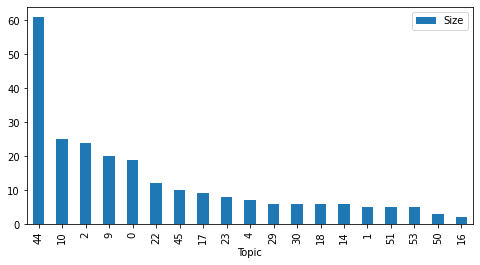

In [167]:
topic_sizes = utils.extract_topic_sizes(docs_df)
topic_sizes.set_index("Topic").plot(kind="bar",figsize=(8,4))

### Let's see how cluster-based TF-IDF selects words describing clusters

# TFIDF on Text



In [187]:
tf_idf, count = utils.c_tf_idf(docs_per_topic.Doc.values, m=len(pdf),ngram_range=(1,1),remove_stop_words=True)
top_n_words = utils.extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
top_6_words_per_topic = pd.DataFrame([(k," | ".join([e[0] for e in v][:6]))  for (k,v) in top_n_words.items()],columns=["Topic","top_n_words"])
top_6_words_per_topic["Topic"]=top_6_words_per_topic["Topic"].apply(int)
topic_sizes = utils.extract_topic_sizes(docs_df)
top_6_words_per_topic=top_6_words_per_topic.set_index("Topic")
pd.set_option('display.max_colwidth', 1000)

top_6_words_per_topic


,top_n_words
Topic,
0,brady | runde | prince | bel | smith | air
1,hamburg | fahrer | fliege | glamping | lawrence | derjährige
2,henssler | zverev | kurz | meyer | witcher | ihm
4,sam | kate | bayern | elena | georgina | asarenka
9,virus | asp | reinking | elke | raab | amos
10,dollar | kardashian | millionen | kubi | thiem | müller
14,eu | china | amar | rigg | camp | europäische
16,hymne | kansas | texans | rassismus | chiefs | themen
17,angelina | netflix | ba | film | brad | cuties


## Let's apply FLAIR-based NER on:
- Raw documents joined together
- Headline + SEO title joined together 

In [169]:
ner_labels = ner_article(docs_per_topic["Raw_Doc"].loc[0])
print(collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower()]).most_common()[:6])



[('Zverev', 66), ('US Open', 51), ('Alexander Zverev', 36), ('Thiem', 24), ('New York', 22), ('Boris Becker', 16)]


In [172]:
ner_labels = ner_article(docs_per_topic["mix"].loc[0])
print(collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower()]).most_common()[:6])

[('US Open', 12), ('Alexander Zverev', 7), ('Dominic Thiem', 5), ('Zverev', 3), ('Alex Zverev', 2), ('Mischa', 2)]


In [256]:
ctrs=[]
start_time = time.time()

for topic in topic_sizes["Topic"].values:
    ner_labels = ner_article(docs_per_topic.set_index("Topic")["Raw_Doc"].loc[topic])
    ctrs.append(collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower() ]).most_common()[:10])
print("--- Documnets NER encoded %s seconds ---" % (time.time() - start_time))
    

In [206]:
dict_with_top_words = {k:v  for k,v in  zip(topic_sizes["Topic"].values,ctrs)}    
dict_with_top_words[1]

[('Kalifornien', 2),
 ('US-Westküste', 1),
 ('US', 1),
 ('Nord-Washington', 1),
 ('Süd-Kalifornien', 1)]

In [173]:
ctrs=[]

start_time = time.time()

for topic in topic_sizes["Topic"].values: # Go over topic labels 
    ner_labels = ner_article(docs_per_topic.set_index("Topic")["mix"].loc[topic])
    counted_word_occurances = collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower() ]).most_common()[:10]
    ctrs.append(counted_word_occurances)
print("--- Titles NER encoded in %s seconds ---" % (time.time() - start_time))
    

--- Titles NER encoded in 179.24954795837402 seconds ---


In [204]:
dict_with_top_words = {k:v  for k,v in  zip(topic_sizes["Topic"].values,ctrs)}    


pd.DataFrame(zip(topic_sizes["Topic"].values,[" | ".join([word[0] for word in word_score]) for word_score in ctrs]),columns=["Topic","TopWords"]).sort_values(by="Topic").set_index("Topic")

,TopWords
Topic,
0,US Open | Alexander Zverev | Dominic Thiem | Zverev | Alex Zverev | Mischa | US | Andy Murray | Serena Williams | US-Open-Halbfinale
1,Kalifornien | US-Westküste | US | Nord-Washington | Süd-Kalifornien
2,Moria | Lesbos | Leipzig | EU | Deutschland | Merkel | deutsche | Chinas | Seehofer | CDU
4,NFL | Bradys | Ex LIVE | NFL-Spieltags | NFL-Saison | NFL NFL | American Football | Patrick Mahomes | Tampa Bay | Tom Brady
9,Ruhrgebiet | Bremen | Düsseldorf | Sachsen-Anhalt | Mercedes | Hamburg | Frankfurt | Hannover | BMW | A57
10,Formel 1 | Sebastian Vettel | Mugello | Ferrari | Aston Martin | Mick Schumacher | Vettel | Lewis Hamilton | Michael | Rossi
14,Indien-Urlaub | Indien
16,Thüringen | Unstrut
17,Leipzig | Lotta | Dortmund | Ruhrgebiet | A5 | Stuttgart | A7 | Hannover | Chemnitz


# Using NER from Google API 

Now for every article let's load list of entities from Google NLP

In [180]:

def parse_google_named_entities(json_obj,deduplicate=False):
    #Parse objets and deduplicate list of them 
    parse_named_entity = lambda ne: {"text":ne["name"],"type":ne["type"]}
    list_of_objects = [parse_named_entity(ne) for ne in json.loads(json_obj)[0]["entities"] if "bild" not in ne["name"].lower() ]
    if not deduplicate:
        return dedupe(list_of_objects)
    else:
        return list_of_objects
    

In [226]:
article_id = 2
parse_google_named_entities(labeled.kicker_headline[article_id]),parse_google_named_entities(labeled.seo_title_ne[article_id])


([{'text': 'Fahrer', 'type': 'PERSON'},
  {'text': 'Führerschein', 'type': 'OTHER'},
  {'text': '510-PS-Flitzerkracht', 'type': 'EVENT'},
  {'text': 'Baum', 'type': 'OTHER'},
  {'text': '510', 'type': 'NUMBER'}],
 [{'text': 'Unfall', 'type': 'EVENT'},
  {'text': 'Hilden', 'type': 'LOCATION'},
  {'text': '510-PS-Flitzer', 'type': 'CONSUMER_GOOD'},
  {'text': '510', 'type': 'NUMBER'}])

In [254]:
ctrs=[]
for topic in topic_sizes["Topic"].values: # Go over topic labels 
    counted_word_occurances = collections.Counter([elem["text"] for elem in docs_per_topic.set_index("Topic").loc[topic]["text_ne"] if not elem['type'] =="NUMBER"]).most_common()[:10]
    ctrs.append(counted_word_occurances)
dict_with_top_words = {k:v  for k,v in  zip(topic_sizes["Topic"].values,ctrs)}    


cluster_labels_google = pd.DataFrame(zip(topic_sizes["Topic"].values,[" | ".join([word[0] for word in word_score]) for word_score in ctrs]),columns=["Topic","TopWords"]).sort_values(by="Topic").set_index("Topic")

In [246]:
from code import modeling

word_embedding_model = models.Transformer(
    'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb')


max_pooling = True

embeddings = modeling.get_sentence_embeddings(X.text.values,word_embedding_model,max_pooling)

N_COMPONENTS=128
alpha=0.825
min_cluster_size=3
min_samples=3
n_neighbors=64

results,cluster_labels = modeling.cluster_and_reduce(embeddings,n_components_clustering=N_COMPONENTS,
                                                                             min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                             min_samples= min_samples,alpha=alpha)


--- Embedding dimension 1536
--- 239 Documnets encoded 22.36236596107483 seconds ---
>> Reducing dimensionality from 1536 to 128 ...
>> Clustering...
>> --- Done in 7.9 seconds ---


Outliers: 0 | Clustered: 239 | 1.0 
 Cluster count: 19 


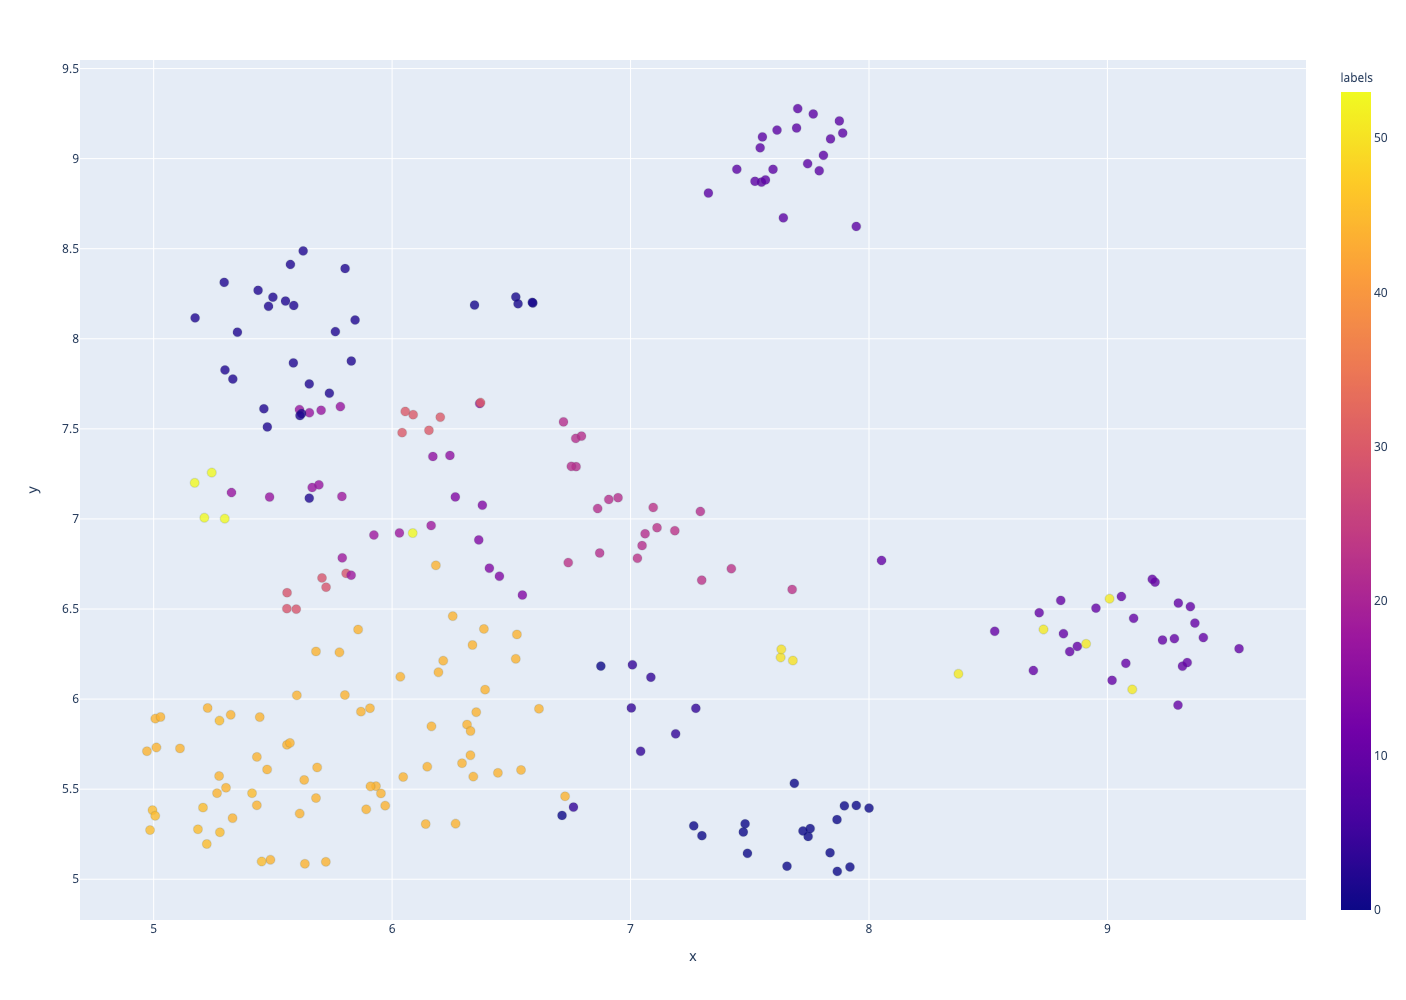

In [265]:
results = utils.link_to_raw_data(results,X,y.values)
                        
results["labels"] = results.labels.apply(int)
results=pd.merge(results,cluster_labels_google.reset_index(),left_on="labels",right_on = "Topic")
fig = px.scatter(results, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords"], color="labels",
                 opacity=0.8)
fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()